# Predicting a Patient's Heart Condition

## Introduction

Heart Disease is a group of conditions that affect the anatomy and function of the heart. The most common type of heart disease is coronary artery disease, or CAD for short, but cardiac arrhythmias, heart valve disease, heart muscle disease, heart infections, and heart failure are all types of heart disease that affect millions of people around the world (Department of Health 2012). Heart disease is ranked as the second highest cause of death in Canada, so this leads us to wonder how a prediction model can save lives by diagnosing those who have heart disease before their lives are at risk (Government of Canada, 2022). We can take a look at various patients' health reports, as well as their diagnoses of heart disease to help us with this and make conclusions on the factors that are most influential in predicting the detection of heart disease in patients.

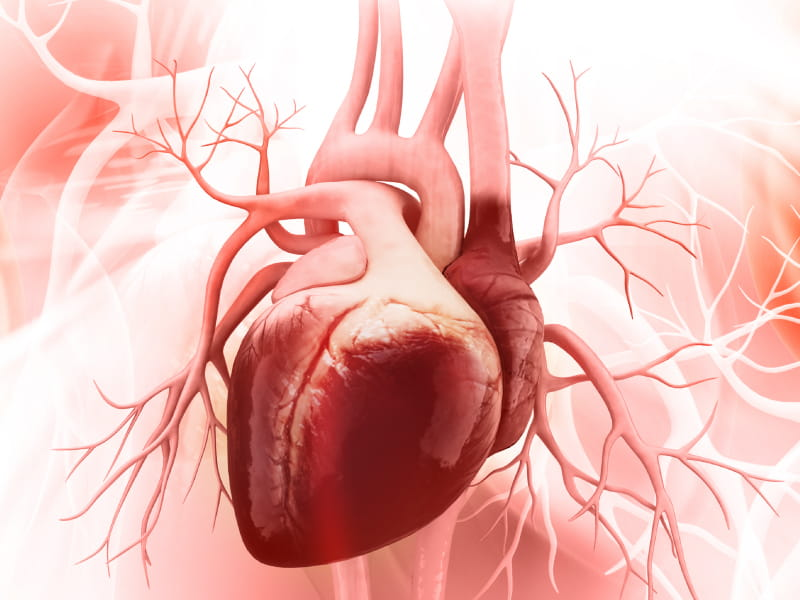     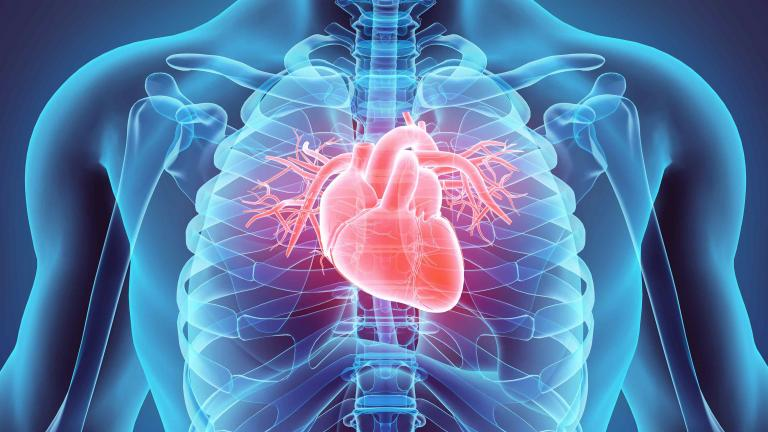     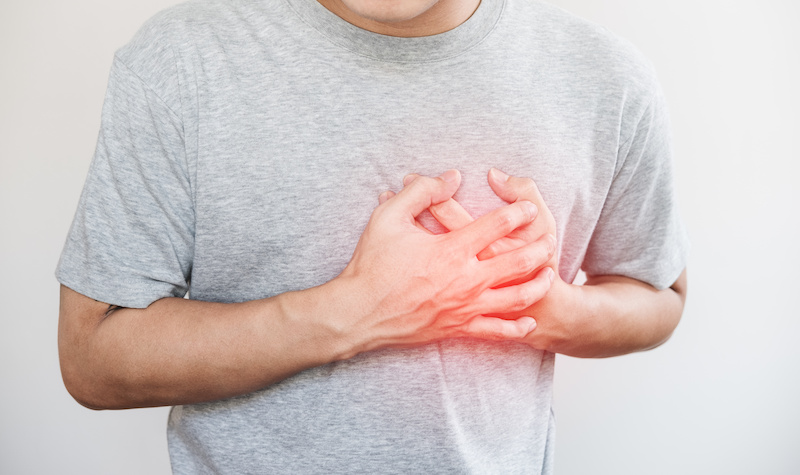

This leads us to question: **Can we predict whether a patient has heart disease based upon the most influential factors within their health report?** 

To answer this question, we will be analyzing a dataset with 14 attributes among 303 patients. This data was retrieved from the `processed.cleveland.data` file in the Heart Disease dataset directory, which can be found here: https://archive.ics.uci.edu/ml/datasets/Heart+Disease (Janosi et al., 1988).

The goal of this project is to create the most accurate classification model to predict the severity of heart disease based on the most influential variables that we choose. Our results will have real-world implications through the prediction of potential heart diseases in patients; however, the lengths to which our model will go depend on its accuracy. The following are all of the attributes found in the dataset.

**Table 0.1**

|Variable|Unit|Values|
|--------|----|---------------|
|Age (age)|Years|Positive Number|
|Sex (sex)|NA|1 = Male, 2 = Female|
|Chest Pain Type (cp)|NA|1 = Typical Angina, 2 = Atypical Angina, 3 = Non-aginal Pain, 4 = Asymptomatic|
|Blood Pressure (trestbps)|mm HG|Positive Number|
|Cholesterol (chol)|mg/dl|Positive Number|
|Fasting Blood Sugar (fbs)|NA|True or False|
|Resting ECG Results (restecg)|NA|0 = Normal, 1 = Abnormal, 2 = Probable or definite left ventricular hypertrophy|
|Maximum Heart Rate (thalach)|bpm|Positive Number|
|Exercise Induced Agina (exang)|NA|0 = No, 1 = Yes|
|Depression Induced by Exercise VS Rest (oldpeak)|NA|ST Depression Scale|
|Slope of the Peak Exercise Segment (slope)|NA|1 = Unsloping, 2 = Flat, 3 = Downsloping|
|Number of Major Vessels (ca)|NA|Integers [1, 3]|
|Heart Condition|NA|3 = Normal, 6 = Fixed Defect, 7 = Reversible Defect|
|Diagnosis of Heart Disease|NA|Integers [0, 4] (0 means non-existent)|

We can see in Table 0.1 that many of the dataset's attributes are categorical variables, so we will need to remove them since our analysis will be composed of a KNN classification model, which for the scope of this class uses only continuous variables as predictors. This includes the age of the patient, blood pressure, cholesterol, maximum heart rate achieved, and depression induced by exercise related to rest to predict the final diagnosis of heart disease.

## Methods

Our general goal is to predict the `num` class by creating a K-NN Classification model with the optimal predictor variables that we will choose. Here are the steps that we will be taking to do this:
1. Read-in and tidy the dataset: Make sure that the tidy dataset criteria are all fulfilled.
2. Train/Test split: Split the dataset into training and testing sets.
3. Analyze and summarise our training set: We will visualize the training data through boxplots to see which variables fluctuate in range and median over different `num` categories.
4. Analyze predictor variables and select the ones of significance: We will create multiple recipes with different predictor variable combinations, and then analyze the resulting accuracy from the cross-validations of each model and choose the most accurate one.
5. Find the optimal $k$ value and build our final model.
6. Evaluation and Conclusion

## 1. Reading and Wrangling the Dataset

#### Loading libraries

In [4]:
library(tidyverse)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 7) #limits output of dataframes to 7 instances

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

#### Reading in and tidying the dataset
* Since the dataset can be read from the internet, it is best to use a URL to read the dataset, as that would allow for the reading of the data without the need for a local file.
* The dataset does not have any column headers, so we must assign their names.
* Many of the variables were of a categoric type, so `as_factor()` will be used to convert them to their appropriate data type.
* The Fasting Blood Sugar levels will be converted to a logical type, as the dataset represents them as either `true` or `false`.
* Since many of the possible predictor variables are not continuous (are categoric), we will have to omit these variables as possible predictors, as using categoric predictor variables in KNN Classification is something outside of the scope of DSCI 100.
    * We will use `select()` to remove these columns.
* Finally, we will remove any `NA` values from our dataset by using `na.omit()`

In [5]:
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
patient_data_refactored <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = names) |>
    mutate(num = as_factor(num)) |>
    mutate(cp = as_factor(cp)) |>
    mutate(sex = as_factor(sex)) |>
    mutate(exang = as_factor(exang)) |>
    mutate(slope = as_factor(slope)) |>
    mutate(restecg = as_factor(restecg)) |>
    mutate(ca = as_factor(ca)) |>
    mutate(thal = as_factor(thal)) |>
    mutate(fbs = as.logical(fbs))

patient_data <- patient_data_refactored |>
    select(-sex, -cp, -restecg, -fbs, -exang, -slope, -ca, -thal)

patient_na_values <- patient_data |>
    filter(age == NA | trestbps == NA | chol == NA | thalach == NA | oldpeak == NA | num == NA)
print("Table 1.1")

patient_na_values

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1.1"


age,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>


* In Table 1.1, we can see that there are 0 instances of any `NA` values.
    * When creating this dataset, the researchers most likely accounted for and removed any `NA` from their observations.
* Table 1.2 below shows the total dataset that we will be using.

In [6]:
print("Table 1.2")
patient_data

[1] "Table 1.2"


age,trestbps,chol,thalach,oldpeak,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,145,233,150,2.3,0
67,160,286,108,1.5,2
67,120,229,129,2.6,1
37,130,250,187,3.5,0
⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1.2,3
57,130,236,174,0.0,1
38,138,175,173,0.0,0


## 2. Splitting the data

* We have decided to split our dataset of 303 instances into a 75% training-testing split, where 75% of our total data will be allocated to our training set to be used in our analysis, cross-validation, and model training, while the other 25% will be used to evaluate our completed model.
* A seed of 100 is also set the `set.seed()` so that our results can be reproduced consistently through the randomness of `initial_split()`.

In [7]:
set.seed(100)
patient_split <- initial_split(patient_data, prop = 0.75, strata = num)
patient_training <- training(patient_split)
patient_testing <- testing(patient_split)

## 3. Analyzing and Summarizing the Training Data
* As stated above, our total dataset contains 303 instances, and since our training set is 75% of that, we would have 225 instances in our training set.

In [8]:
n_for_nums <- patient_training |>
    group_by(num) |>
    summarize(n = n())

print("Table 3.1: Distribution of Diagnoses")
n_for_nums

[1] "Table 3.1: Distribution of Diagnoses"


num,n
<fct>,<int>
0,123
1,40
2,27
3,25
4,10


* By using `group_by()` with `num` as its parameter, and `summarize()` with `n = n()` as its parameter, a tibble that contains the number of instances for each `num` type is created.
* We can see here that most of our training data (around 55%) are composed of patients who do not have heart disease, so it has a much higher ratio within the training set compared to the other diagnoses.
* The number of instances also appears to decrease as the severity of the diagnosis increases, which implies that severe heart disease occurs less in patients.

In [9]:
mean_per_diagonsis <- patient_training |>
    group_by(num) |>
    summarize(mean_age = mean(age), mean_trestbps = mean(trestbps), mean_chol = mean(chol), mean_thalach = mean(thalach), mean_oldpeak = mean(oldpeak))
print("Table 3.2: Mean of Variables Across Diagnoses")
mean_per_diagonsis

[1] "Table 3.2: Mean of Variables Across Diagnoses"


num,mean_age,mean_trestbps,mean_chol,mean_thalach,mean_oldpeak
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,53.05691,130.4390,240.6179,157.8211,0.6642276
1,55.65000,133.8250,245.9000,145.5000,0.9850000
2,57.92593,136.3333,258.1111,138.8889,1.6185185
3,56.00000,135.6000,244.7200,134.2000,1.9800000
4,58.60000,134.4000,242.4000,142.5000,2.3100000


* Again, `group_by()` and `summarize()` are used to group the data by their `num` diagnoses, and then to find the means of all the data within those subgroups.
* We can see that in Table 3.2, patients with a `num` = 0 are on average, only around 3 years younger than patients who have `num` = 1. 
* Depression induced by exercise (`oldpeak`), seems to be in a positive relationship with the diagnoses.
* The maximum heart rate of a patient (`thalach`) is higher for patients without heart disease compared to patients who do.
    * This could mean that `thalach` could help determine if a patient's `num` value is greater than zero (has heart disease), but not as well with the severity.
* It seems that many of the values across diagnoses seem to have similar or slightly different mean values, which may be a point of concern for our model.

#### Visualizing the predictor variables

[1] "Figure 3.3: Variable Distributions Across Diagnoses"


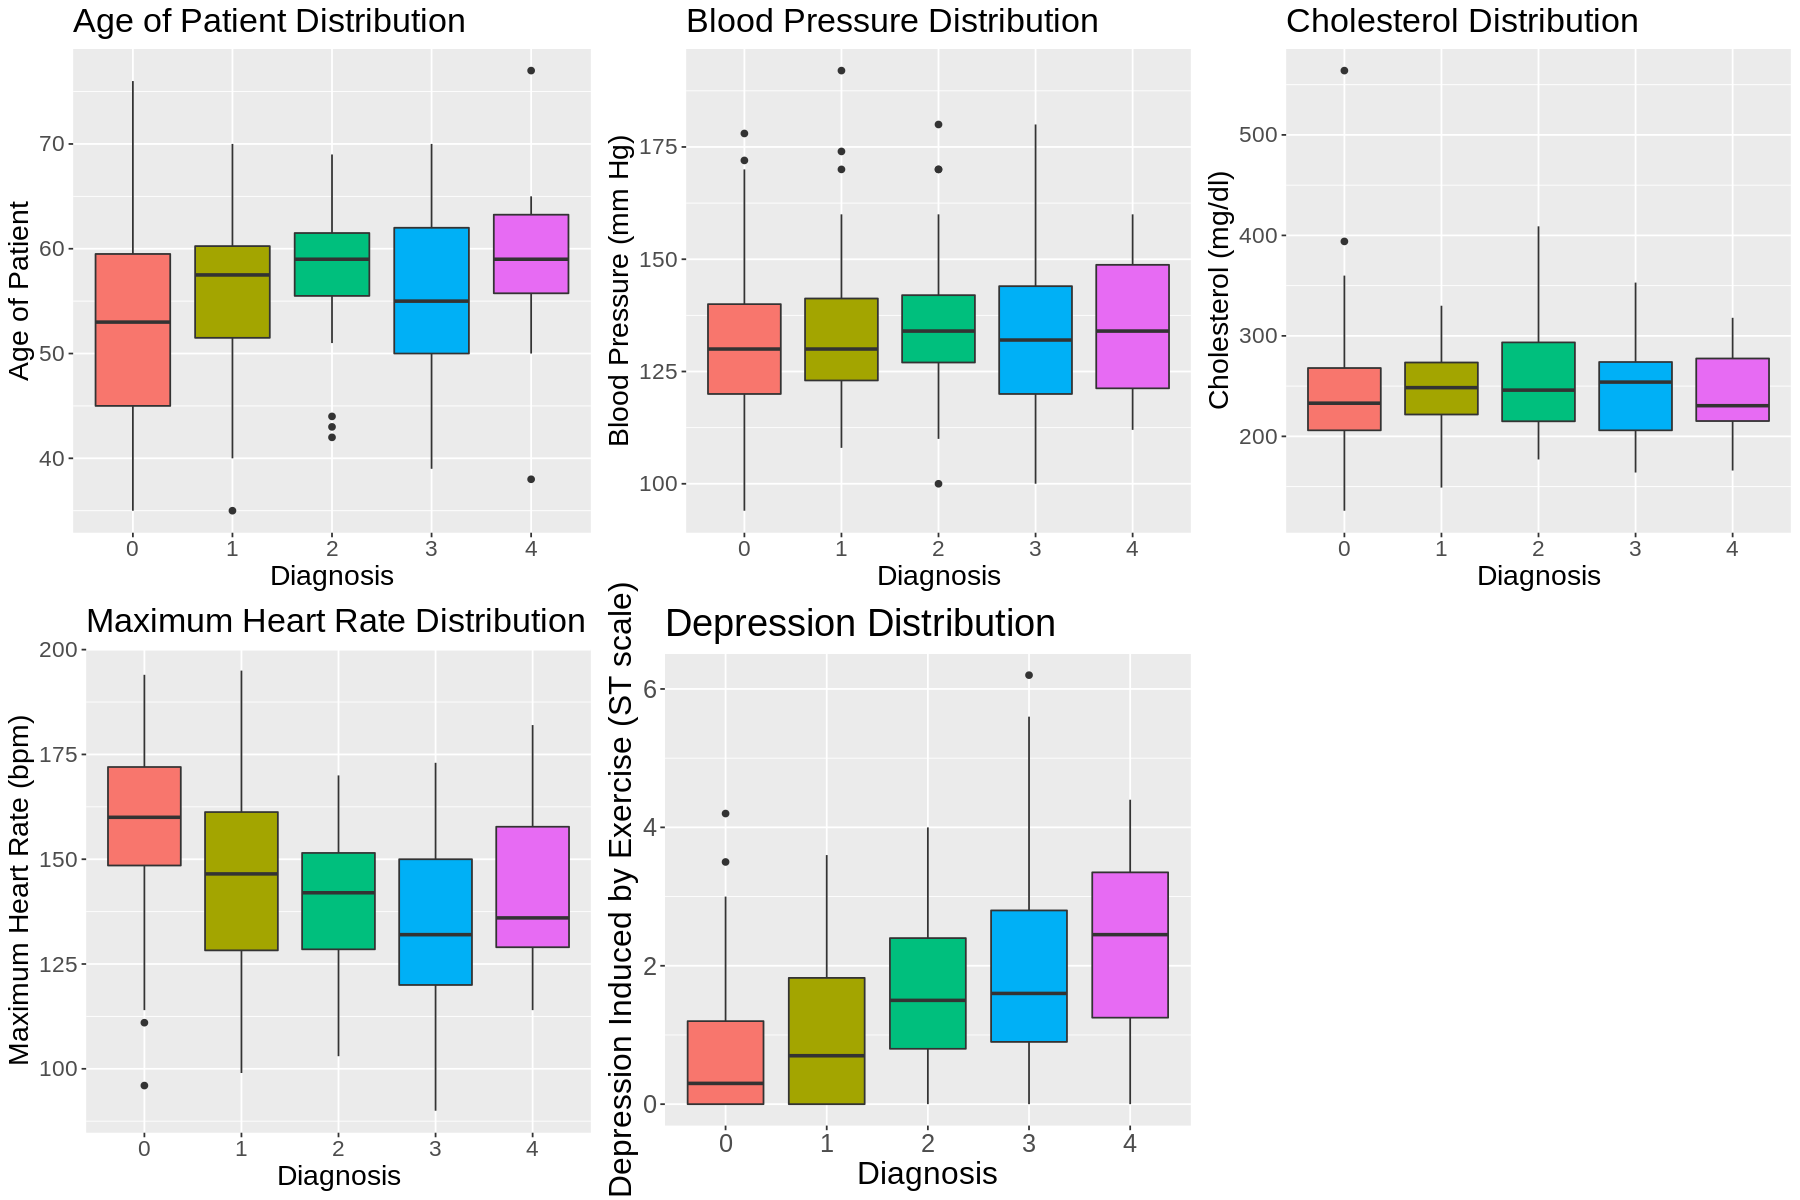

In [10]:
options(repr.plot.width = 15, repr.plot.height = 10)
age_boxplot <- patient_training |>
    ggplot(aes(x = num, y = age, fill = num)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Age of Patient") +
    ggtitle("Age of Patient Distribution") +
    theme(text = element_text(size = 17))
testbps_boxplot <- patient_training |>
    ggplot(aes(x = num, y = trestbps, fill = num)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Blood Pressure (mm Hg)") +
    ggtitle("Blood Pressure Distribution") +
    theme(text = element_text(size = 17))
chol_boxplot <- patient_training |>
    ggplot(aes(x = num, y = chol, fill = num)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Cholesterol (mg/dl)") +
    ggtitle("Cholesterol Distribution") +
    theme(text = element_text(size = 17))
thalach_boxplot <- patient_training |>
    ggplot(aes(x = num, y = thalach, fill = num)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Maximum Heart Rate (bpm)") +
    ggtitle("Maximum Heart Rate Distribution") +
    theme(text = element_text(size = 17))
oldpeak_boxplot <- patient_training |>
    ggplot(aes(x = num, y = oldpeak, fill = num)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Diagnosis", y = "Depression Induced by Exercise (ST scale)") +
    ggtitle("Depression Distribution") +
    theme(text = element_text(size = 19))
predictor_visualization <- plot_grid(age_boxplot, testbps_boxplot, chol_boxplot, thalach_boxplot, oldpeak_boxplot, ncol = 3)

print("Figure 3.3: Variable Distributions Across Diagnoses")
predictor_visualization

* By utilizing `ggplot()` and `geom_boxplot()`, we can visualize the range of values between each predictor variable.
* We can see that for this specific train/testing split, our training data resulted in the variables `age` (age), `thalach` (maximum heart rate), and `oldpeak` (depression) varying in range and median the most across different diagnoses.
    * This means that they may have a significant impact on the diagnosis of a patient, and should be chosen as our predictor variables to test.
* Cholesterol and Blood Pressure appear to stay relatively constant, especially in the median, across different diagnoses.
    * This means that they have little impact on the diagnosis of a patient, so they would be of little use to our final model.

#### The predictor variables that we will test are: `age`, `thalach`, and `oldpeak`.

## 4. Analyzing and Selecting Predictor Variables

* To select our predictor variables, we will tune models and create distinct recipes for each set of predictor variables, and then compare the accuracy of the models.
* We will set `neighbors` to `tune()` in our K-NN recipe in combination with 5-fold cross-validation so that each model that we compare will be at its optimal accuracy.
    * Note that `k` values used for the cross-validation will be values from 1 to 50.
        * For now, it does not completely matter if the accuracy is maximized (if we have the best `k` value), as we are analyzing how a predictor variable affects the model.
* The data must also be scaled and centered, as the ranges of variables are different.

In [11]:
patient_vfold <- vfold_cv(patient_training, v = 5, strata = num)

gridvals <- tibble(neighbors = seq(1, 50))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [12]:
a_recipe <- recipe(num ~ age, patient_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

a_results <- workflow() |>
    add_recipe(a_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = patient_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

a_results_best <- a_results |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(mean)

! Fold5: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



In [13]:
at_recipe <- recipe (num ~ age + thalach, patient_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

at_results <- workflow() |>
    add_recipe(at_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = patient_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

at_results_best <- at_results |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(mean)

! Fold5: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



In [14]:
ato_recipe <- recipe (num ~ age + thalach + oldpeak, data = patient_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

ato_results <- workflow() |>
    add_recipe(ato_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = patient_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

ato_results_best <- ato_results |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(mean)

! Fold5: internal:
  No observations were detected in `truth` for level(s): '4'
  Computation will proceed by ignoring those levels.



In [15]:
model <- c("num ~ age", "num ~ age + thalach", "num ~ age + thalach + oldpeak")
accuracies <- c(a_results_best, at_results_best, ato_results_best)
acc_table <- tibble(`Recipe Input` = character(), Accuracy = numeric()) |>
    add_row(`Recipe Input` = model, Accuracy = accuracies)

print("Table 4.1: Resulting Accurracies of Different Predictor Variables")
acc_table

[1] "Table 4.1: Resulting Accurracies of Different Predictor Variables"


Recipe Input,Accuracy
<chr>,<dbl>
num ~ age,0.5472078
num ~ age + thalach,0.5514631
num ~ age + thalach + oldpeak,0.5608579


* From the tabel above, we can conclude that all three of these predictor variables help our model (are meaningful) and increase the prediction accuracy.
* Knowing this, we can now use the recipe with all three predictor variables to build our model.
* However, we can notice here that our accuracies are slightly above 50%, so we can begin to think of the applications of our model.

## 5. Finding the Optimal `k` Value and Building the Final Model

* First, we will build new components that need to be updated for our final model.
    * Mainly, we need a new set of `k` values to test and a new workflow.
* We will then tune our model with various `k` values, and pick the best one through a visualization.

In [ ]:
k_values <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

# patient_vfold, ato_recipe, and knn_spec are previously defined
patient_results <- workflow() |>
    add_recipe(ato_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = patient_vfold, grid = k_values) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

In [ ]:
options(repr.plot.width = 14, repr.plot.height = 7)

best_k_y <- patient_results |>
    filter(neighbors == 50) |>
    pull(mean)

k_accuracies_plot <- patient_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 50, colour = "steelblue3") +
    geom_point(aes(x = 50, y = best_k_y), size = 3, colour = "blue") +
    labs(x = "K Value", y = "5 Average CV Accuracy") +
    ggtitle("Figure 5.1: Accuracies Across Different K Values") +
    theme(text = element_text(size = 20))

k_accuracies_plot

* We can see in Figure 5.1 that at `k = 50`, there is a 3-point maximum plateau.
    * This shows that there is a consistency in the maximum value, which increases the validity of this value.
* Knowing this, we will choose a value of `k = 50` for our model.

### Building the Final Model


* We will create a new model specification and a new workflow with our selected `k` value.

In [ ]:
best_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 50) |>
  set_engine("kknn") |>
  set_mode("classification")

# ato_recipe is previously defined
patient_fit <- workflow() |>
    add_recipe(ato_recipe) |>
    add_model(best_knn_spec) |>
    fit(data = patient_training)

print("Figure 5.2: Final Classification Model")
patient_fit

## 6. Evaluation the Model and Conclusion

* Now, we will evaluate the model that we have created by fitting our testing set (`patient_testing`) with `patient_fit`.

In [ ]:
patient_predictions <- predict(patient_fit, patient_testing) |>
    bind_cols(patient_testing)
patient_acc <- patient_predictions |>
    metrics(truth = num, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1)

print("Table 6.1: Model Accuracy on the Testing Set")
patient_acc

In [ ]:
options(repr.plot.width = 7, repr.plot.height = 7)

patient_matrix <- patient_predictions |>
    conf_mat(truth = num, estimate = .pred_class)
patient_matrix <- autoplot(patient_matrix, type = "heatmap") +
    scale_fill_gradient(low="#D6EAF8",high = "#2E86C1") +
    labs(title = "Figure 6.2: Confusion Matrix of the Results") +
    theme(text = element_text(size = 20))

patient_matrix

* From Figure 6.2, we can see that our model had a prediction accuracy of 54% when classifying the observations of the testing set.
* However, we can see that almost all of the correct predictions were made on patients that did not have heart disease.
    * This may be because our dataset is composed mostly of patients who do not have heart disease, so our model may be overfitted with a large number of `num = 0` instances.

In [ ]:
print("Table 3.2")
mean_per_diagonsis

* In addition, if we look at Table 3.2 again, we can see that the means of the predictor values are relatively similar (mentioned in Section 3), so our model may have trouble distinguishing observations and produce `num = 0` as a result of the overfitting.

In [ ]:
options(repr.plot.width = 17, repr.plot.height = 7)
age_vs_thalach <- patient_data |>
    ggplot(aes(x = age, y = thalach)) +
    geom_point(color = "red") +
    labs(title = "Age VS Maximum Heart Rate", x = "Age (Years)", y = "Maximum Heart Rate (bps)") +
    theme(text = element_text(size = 17))

thalach_vs_oldpeak <- patient_data |>
    ggplot(aes(x = thalach, y = oldpeak)) +
    geom_point(color = "blue") +
    labs(title = "Maximum Heart Rate VS Depression", x = "Maximum Heart Rate (bps)", y = "Depression (ST scale)") +
    theme(text = element_text(size = 17))

age_vs_oldpeak <- patient_data |>
    ggplot(aes(x = age, y = oldpeak)) +
    geom_point(color = "black") +
    labs(title = "Age VS Depression", x = "Age (Years)", y = "Depression (ST scale)") +
    theme(text = element_text(size = 17))

predictor_relation_plot <- plot_grid(age_vs_thalach, thalach_vs_oldpeak, age_vs_oldpeak, ncol = 3)

print("Figure 6.3")
predictor_relation_plot

* Finally, in Figure 6.3 above, we can see that there is little to no trend between different combinations of variables.
    * The points spread to different places without any noticeable bias or trends.
* This means that the predictor variables were chosen well, as they are independent of each other and minimize the chances of multicollinearity.

## Discussion

As seen in our report above, we discovered that age, maximal heart rate, and depression were the most important risk factors for heart disease in Section 3 (from the data that we were able to analyze). Out of these predictors, Table 4.1 revealed that using all three of them would lead to the most accurate model, and that model resulted in a 54% accuracy on the testing dataset. These variables are a good reflection of the real-world perpetrators of heart disease because, according to the Centers for Disease Control and Prevention, low physical activity is a major cause of heart disease, which directly relates to our variables oldpeak, age, and thalach. However, they also state that cholesterol levels are important in determining heart disease as well, but our testing set showed little variance in cholesterol levels over the diagnoses. This may mean that our training set may not be the best representation of the world population, possibly due to the sample size or sampling biases that may have been present during the collection of our dataset.
Our accuracy result was to be expected, as we had to cut out many variables that could increase our accuracy because their data types were not continuous. In addition, our model predicted that most of the patients in the testing set patients to be disease-free, even if they truly did have heart disease. This may be a result of our training set being composed of mostly num values of 0 as seen in Table 3.1, which resulted in overfitting. Knowing this, our model's implementation in the real world may be limited, since professional diagnoses must be made with extreme certainty. Our current model may only be useful in preliminary speculation on if someone has a disease, as accuracy may not be life-threatening in the early phases of diagnosis. Hopefully, professionals can implement more continuous variables into our methods to create higher accuracy that can be used to help people in environments such as hospitals.

Some questions for the future of this research include:

* Can our model be converted into one that predicts other diseases such as cancer and AIDS?
* How will our model react to the introduction of vaccines and cures?
    * How frequently would our model have to be re-trained?
* Can different models be made to suit different degrees of diagnosis?
    * Can we make reliable, semi-accurate models that are cheaper to train for small medical clinics, and also reliable, high-accuracy yet expensive models for professionals?

## References

Government of Canada, P. H. A. of. (2022). Heart Disease in Canada. Canada.ca. Retrieved November 28, 2022, from https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html 

Department of Health. Types of Cardiovascular Disease. (2012). Retrieved November 28, 2022, from https://www.health.ny.gov/diseases/cardiovascular/heart_disease/types_of_cv.htm 

Janosi, A., Steinbrunn, W., Pfisterer, M., &amp; Detrano, R. (1988). UCI Machine Learning Repository: Heart disease data set. Retrieved November 28, 2022, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease